**Author:** Alex Dawson-Elli  
**Assignment:** Homework 1  
**Due:** 2/2/2018



## Problem 1:
solve the following linear program using Clp Ecos and SCS solvers. Compare the answers found by each solver

objective fxn:  
$5x_1 - x_2 + 11x_3$  

constraints:  
  $2x_1 ≥ x_2 + x_3$  
  $ ≤ x_j ≤ 3, j ∈ {1, 2, 3}$



we will define our problem statement in a modular function to keep code DRY

In [21]:
#define the problem, independent of solver used:
using JuMP, Clp, ECOS, SCS

"""setup a model given the supplied model type"""
function setup(m)
    @variable(m, 0 <= x₁ <= 3)          
    @variable(m, 0 <= x₂ <= 3)
    @variable(m, 0 <= x₃ <= 3) 
    @constraint(m,  x₂ + x₃ <= 2x₁)          
    @objective(m, Max, 5x₁ - x₂ + 11x₃)          
    return m
end

"""
profile code and display results:
"""
function profile(m)
    @time(for i = 1:1000 solve(m) end)
    println("x₁ = " , getvalue(m.objDict[:x₁]))
    println("x₂ = " , getvalue(m.objDict[:x₂]))
    println("x₃ = " , getvalue(m.objDict[:x₃]))
    println("max value is:", getobjectivevalue(m))   
end

profile

In [2]:
#evaluate model
m = Model(solver = ClpSolver())
m = setup(m)

Maximization problem with:
 * 1 linear constraint
 * 3 variables
Solver is ClpMathProg

In [22]:
#use Clp solver
m = Model(solver = ClpSolver())
m = setup(m)
profile(m)

  0.206704 seconds (36.03 k allocations: 2.413 MiB)
x₁ = 3.0
x₂ = 0.0
x₃ = 3.0
max value is:48.0


In [23]:
#use ECOS solver 
m = Model(solver = ECOSSolver((verbose=0)))
m = setup(m)
profile(m)

  0.309517 seconds (493.09 k allocations: 28.327 MiB, 2.08% gc time)
x₁ = 2.999999998571697
x₂ = 8.223270148055816e-9
x₃ = 3.000000000197723
max value is:47.999999986810174


In [24]:
#use SCS solver 
m = Model(solver = SCSSolver((verbose=0)))
m = setup(m)
profile(m)

  0.317732 seconds (393.07 k allocations: 22.878 MiB, 1.73% gc time)
x₁ = 2.9999856529908175
x₂ = 4.149724927436506e-6
x₃ = 3.0000130627112145
max value is:48.000067805052524


## problem 1 answers
**a) which solver is more accurate? **
accuracy is easy to judge for a simple linear program like this by thinking graphically. The three constraints 0 ≤ xj ≤ 3, j ∈ {1, 2, 3} form a bounding cube that must contain the optimal solution (feasable set). The additional constraint  2x1 ≥ x2 + x3 further reduces the feasable set, and from the analysis presented at the end of lecture 2, the optimal solution of linear programs occures at verticies of the feasable polygon. since 2x1 = x2 + x3 is not parellel to any one side of the cube, this suggests that the optimal solution will have at least 2 or $[x_1 x_2 x_3]$ = 3, so we can say that say that an accurate solution should have an integer solution. Only the CLP algorithm has a truely integer solution, the rest have very close to integer solutions, but are slightly off, with ECOS having better accuracy than SCS.


**b) which solver is the fastest?** lets begin by looking at the data, and then we will explain the data through principles from class. In order of speed, CLP<ECOS<SCS for 1000 executions of the solver. This agrees with the relationship between the generality of an algorithm, and its speed on a particular problem. 
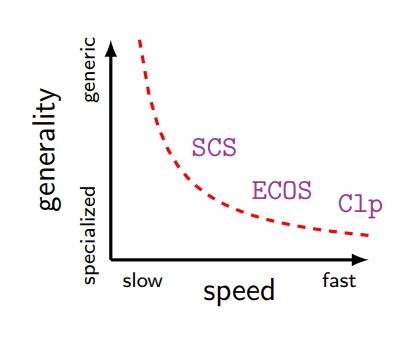
CLP is written specifically to solve linear programs, so it does so with the highest efficiency. ECOS bo comparison is more general in that it solves second order cone problems, and LP⊆SOCP⊆SDP. The last point leads us to the conclusion that SCS should be slower than either Clp or ECOS, and experiment deminstrates this to be the case.


## problem 2: 


Translating from words into tables, we see arrive at:

Objective:
$200w + 300c$

The Recipe:

|     |labor    | fertilizer   | acres |
|:---:|:-------:|:------------:|:-----:|
|wheat|   3     |      2       |   1   |
|corn |   2     |      4       |   1   |


The Stock:

|labor    | fertilizer   | acres |
|:-------:|:------------:|:-----:|
|   100   |      120     |   45  |


#### a) solve the optimization problem:

In [87]:
using JuMP, Clp, ECOS, SCS

m = Model(solver = ClpSolver())

#form model constraints
@variable(m, w >= 0)                           #wheat
@variable(m, c >= 0)                           #corn
@constraint(m, 0 <= 3w + 2c <= 100)            #labor
@constraint(m, 0 <= 2w + 4c <= 120)            #fertilizer          
@constraint(m, 0 <=  w +  c <= 45)             #acres       
@objective(m, Max, 200w + 300c)   

solve(m);

In [22]:
println("w = " , getvalue(m.objDict[:w]))
println("c = " , getvalue(m.objDict[:c]))
println("optimal solution is ", getobjectivevalue(m)) 

w = 19.99999999999999
c = 20.000000000000007
optimal solution is 10000.0


#### b) separate parameters from the solution  
Here we will solve the same problem again, but using structures to separate parameters from the model. This abstraction allows for easier changing of problems which are of the same class (in this case, a linear program)

In [85]:
# the types of crops produced
crops = [:wheat, :corn]

#resource based constraints
resources = [:labor , :fertilizer, :acres]

# profits 
profit = Dict( zip( crops, [ 200, 300 ] ) )

# quantities available (for each ingredient)
quantAvail = Dict( zip( resources, [ 100, 120, 145 ] ) )

# recipes (crops, resources)
using NamedArrays
recipeMat = [ 3 2 1 
               2 4 1 ]
recipe = NamedArray( recipeMat, (crops,resources), ("crops","resources"))

2×3 Named Array{Int64,2}
crops ╲ resources │      :labor  :fertilizer       :acres
──────────────────┼──────────────────────────────────────
:wheat            │           3            2            1
:corn             │           2            4            1

In [89]:
using JuMP, Clp
m = Model(solver = ClpSolver())

@variable(m, plants[crops] >= 0 )
@expression(m, totalProfit, sum( profit[c]*plants[c] for c in crops) )
@constraint(m, constr[i in resources], sum( recipe[c,i]*plants[c] for c in crops ) <= quantAvail[i] )
@objective(m, Max, totalProfit )

 solve(m)
 println(getvalue(plants))
 println("Total profit is: \$", getvalue(totalProfit))

plants: 1 dimensions:
[wheat] = 19.99999999999999
[ corn] = 20.000000000000007
Total profit is: $10000.0


#### c) solve problem graphically:
from our variable definitions (box constraints) , w and c must both be positive, which limits the feasable region to quadrant I (only positive quantities). From our constraint equations, we can form the equations that specifiy the outer boundry of the feasable region, as shown in the following graph:






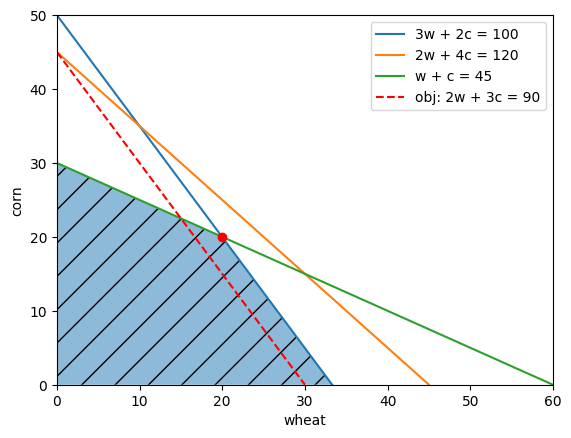

In [86]:
using PyPlot

#plot using c and w using intercepts (calculated manually)
axis([0,60, 0, 50])
plot([0,33.3],[50,0]) 
plot([0,45],[45,0]) 
plot([0,60],[30,0]) 

#plot the contour lines
plot([0,30],[45,0], "r--" )

#plot the optimal intercept
plot([20],[20],"ro")

#labeling
legend(["3w + 2c = 100", "2w + 4c = 120", "w + c = 45","obj: 2w + 3c = 90"])
xlabel("wheat")
ylabel("corn")

#fill the feasable region for swagger points
fill_between([0,20,33.3],[30,20,0], [0,0,0], hatch = "/", alpha = .5);



The dashed red line line represents a sampling of the objective function as we move it in the feasable region. The maximum solution occures when the red dotted line intercepts the red dot. Lets find this dot analytically, as it is the intersection point of 3w + 2c = 10 and w + c = 45

In [82]:
A = [3 2 ; 2 4 ]
b = [100 120]';


well solve the equation: 
$$
Ax = b
$$

where:

$$
\begin{bmatrix}
     3& 2 \\
     2& 4 \\
\end{bmatrix}
x = 
\begin{bmatrix}
     100 \\
     120 \\
\end{bmatrix}
$$


In [83]:
A\b

2×1 Array{Float64,2}:
 20.0
 20.0

so our solution is 
$$
c = 20, w = 20
$$

which is in agreement with our optimization result